# 0.0. IMPORTS

In [1]:
import pickle
import psycopg2
import warnings


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display       import Image
%matplotlib inline

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [42]:
def get_tables(table):
    '''This functions receives a list with table names to be loaded from the database'''
    # to create a df to store all loaded dfs
    df_tab = pd.DataFrame()
    
    # iterate over the list of tables, load each one, take the column names and create a final df
    for tab in table:
        sql = 'SELECT * FROM pa004.{}'.format(tab)
        cur.execute(sql)
        cols = [desc[0] for desc in cur.description] # saving the column names
        data = []
        for i in cur:
            data.append(i)
        df = pd.DataFrame(data, columns = cols)
        
        if 'id' in df_tab:
            df_tab = df_tab.merge(df, how = 'left', left_on = 'id', right_on = 'id')
        else:
            df_tab = df.copy()
    return df_tab

def num_descriptive(num_attributes):
    # Central Tendendy - mean, median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersion - std, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
    d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


    # concatenating them and printing
    m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
    return m

## 0.2. Collecting the Data

In [35]:
# creating parameters  to access the database
params = dict(
    database='',
    user='',
    password='',
    host='',
    port=
)
# creating the connection
conn = psycopg2.connect(**params)

# creating the cursor
cur = conn.cursor()

**Let's find out how many tables there are**

In [36]:
sql = "select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)'"
cur.execute(sql)
tables = cur.fetchall()
table_names = []
for table, database in enumerate(tables, start=1):
    table_names.append(database[0])
    print(f'Table {table}: {database[0]}')

Table 1: users
Table 2: vehicle
Table 3: insurance


**Now, let's load them all and store them in a single dataframe.**

In [48]:
#df_raw =  get_tables(table_names) # fucntion defined in section 0.1: Helper Functions
#cur.close()
#conn.close()

#pickle.dump( df_raw, open( '../data/df_raw.pkl', 'wb') ) # saving the df as pickle format

In [8]:
df_raw = pickle.load(open('../data/df_raw.pkl', 'rb'))

In [45]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


# 1.0. STEP 1: DATA DESCRIPTION

In [33]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [47]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.8+ MB


## 1.3. Checking for Missing Values

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Checking the Target Balance


In [13]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

So, the data is very unbalanced.

## 1.5. Descriptive Statistics

In [35]:
num_attributes = df1[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']]
cat_attributes = df1.drop(['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage'], axis = 1)

### 1.5.1 Numerical Attributes

In [49]:
num_descriptive(num_attributes) # fucntion defined in section 0.1: Helper Functions

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,age,20.0,85.0,65.0,25.0,36.0,49.0,38.822584,15.511591,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,15.0,28.0,35.0,26.388807,13.229871,-0.115266,-0.867857
2,policy_sales_channel,1.0,163.0,162.0,29.0,133.0,152.0,112.034295,54.203924,-0.900008,-0.970810
3,annual_premium,2630.0,540165.0,537535.0,24405.0,31669.0,39400.0,30564.389581,17213.132474,1.766087,34.004569
4,vintage,10.0,299.0,289.0,82.0,154.0,227.0,154.347397,83.671194,0.003030,-1.200688


**Conclusions**:
- `age` seems not to have any inconsistent value (minimum of 20 and maximum of 85).
- `annual_premium` shows a large range, meaning that there're customers who paid too little and too much to the company
- Skewness:
    + all variables have a low skewness. 
    + `region_code` and `policy_sales_channel` have negative skewness, meaning that the observations are slightly concentrated on the the right side of the distribution;
    + `age` and `annual_premium` have a low positive skewness, meaning that the observations are slightly concentrated on the left side of the distribuition.
- Kurtosis:
    + except by `annual_premium`, all vfariables have a low kurtosis coefficient, meaning that there are fewer values close to the mean (Platykurtic). `annual_premium`, otherwise, have a very leptokurtic distribution, meaning that there are more values close to the mean.

### 1.5.2. Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

id                    381109
gender                     2
driving_license            2
vehicle_age                3
vehicle_damage             2
previously_insured         2
response                   2
dtype: int64

# 2.0. STEP 2: FEATURE ENGINEERING AND HYPOTHESIS CREATION

In [ ]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

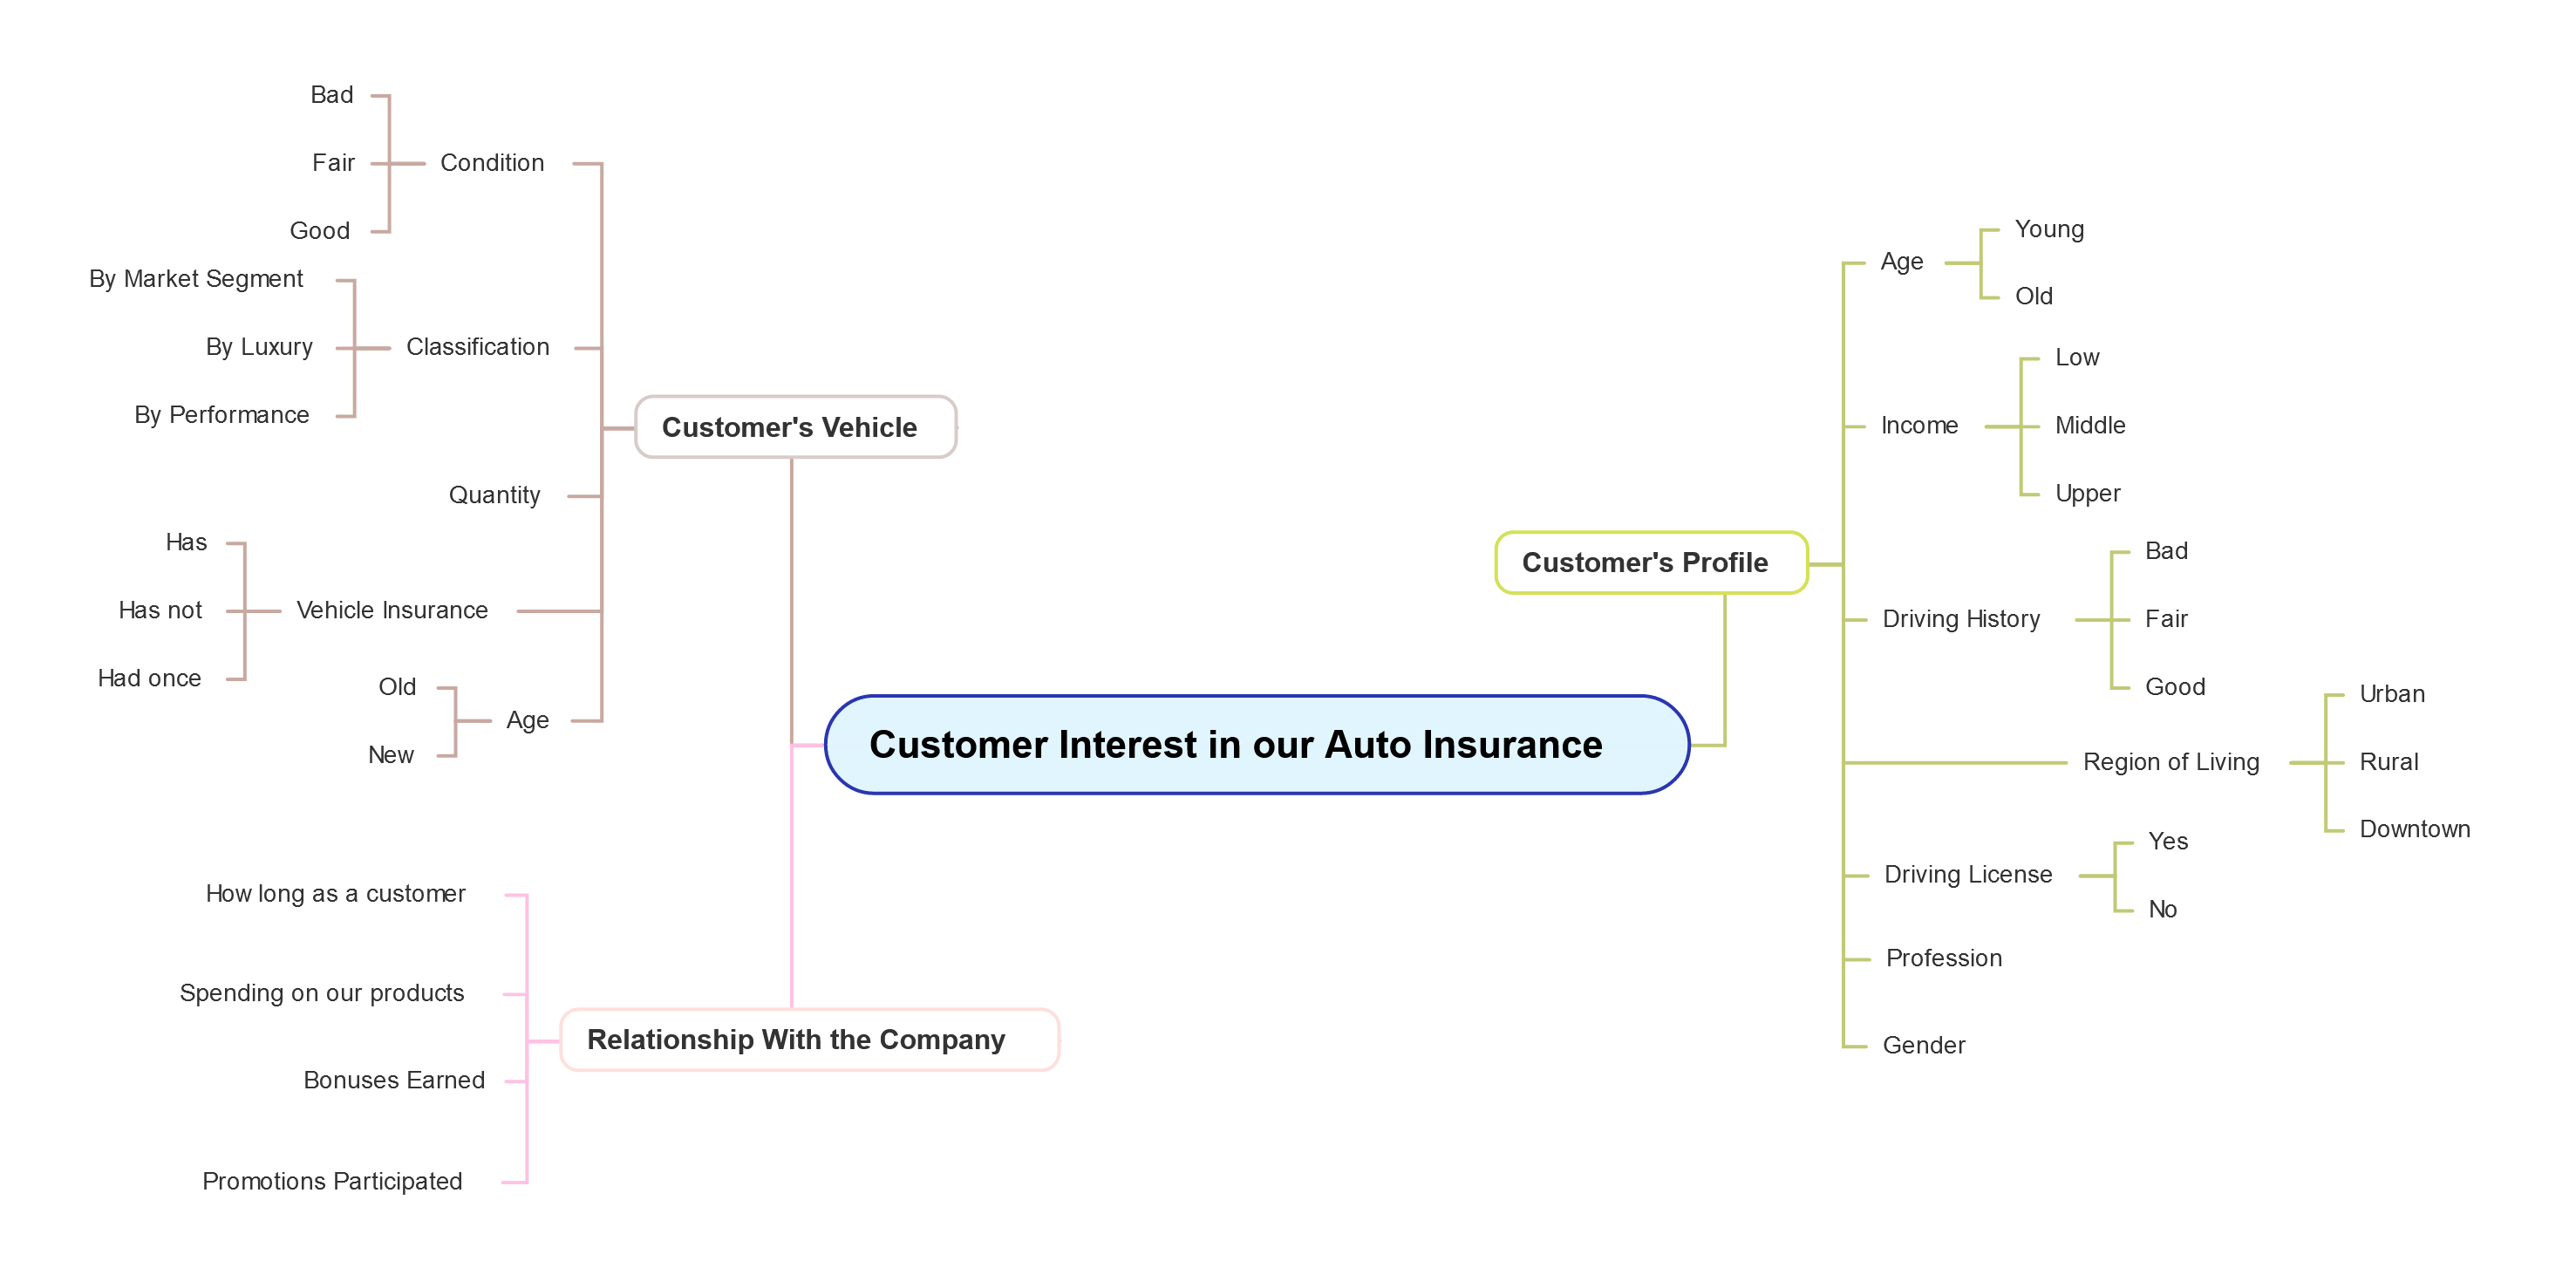

In [3]:
Image( '../imgs/mind_map.png' )

## 2.2. Hypothesis Creation

### 2.2.1. Customer's Profile Hypothesis

**1.** Older customers should be more likely to purchase the vehicle insurance.

**2.** The higher the customer's income, the more likely he/she should be to purchase the insurance.

**3.** Customers who have a bad driving history should be more likely to purchase the vehicle insurance.

**4.** Customers from a dangerous region should be more likely to purchase the vehicle insurance.

**5.** Customers who have driving license should be more likely to purchase the vehicle insurance.

**6.** Customers who live far from home should be more likely to purchase the vehicle insurance.

**7.** Customers who use their own vehicle at work should be more likely to purchase the vehicle insurance.

**8.** Women are more likely to purchase a vehicle insurance than men.

### 2.2.2. Relationship with the Company

**1.** The longer as a customer, the more likely to purchase the vehicle insurance he/she should be.

**2.** Customers who have had purchased our health insurance should be more likely to purchase our vehicle one.

**3.** The more the customer spent on our products, the more he/she should be to purchase the vehicle insurance.

**4.** Customers who have ever earned some bonus should be more likely to purchase the vehicle insurance.

**5.** Customers who have ever participated in promotions should be more likely to purchase the vehicle insurance.

### 2.2.3. Vehicle

**1.** The younger the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**2.** The better the customer's vehicle condition, the more likely he/she should be to purchase the vehicle insurance.

**3.** The higher the quantity of vehicles a customer has, the more likely the/she should be to purchase the vehicel insurance.

**4.** The more expensive the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**5.** Customers who don't have a vehicle insurance should be more likely to purchase one.

## 2.3. Hypothesis Final List

Now, we'll filter some hypothesis based on availability of data. After look at the dataset we adapted some hypothesis to fit the data we have, since we need to look at the feature's relevance in EDA section.

**1.** Older customers should be more likely to purchase the vehicle insurance.

**2.** Customers who have driving license should be more likely to purchase the vehicle insurance.

<s>**3.** Customers who have a bad driving history should be more likely to purchase the vehicle insurance.</s><br>
**3.** Customers who have their vehicles damagedin the past should be more likely to purchase the vehicle insurance.

**4.** Women are more likely to purchase a vehicle insurance than men.

<s>**5.** Customers from a dangerous region should be more likely to purchase the vehicle insurance.</s><br>
**5.** The customer's interest for vehicle insurance should differ between region codes.

**6.** The longer as a customer, the more likely to purchase the vehicle insurance he/she should be.

**7.** The more the customer spent on our products, the more he/she should be to purchase the vehicle insurance.

**8.** The younger the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**9.** Customers who don't have a vehicle insurance should be more likely to purchase one.

## 2.4. Feature Engineering